action mask:  tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False,  True, False,  True, False, False, False, False, False, False,
         False, False,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False,  True, False, False, False,
         False, False, False, False, False,  True, False,  True, False, False,
         False, False, False, False, 

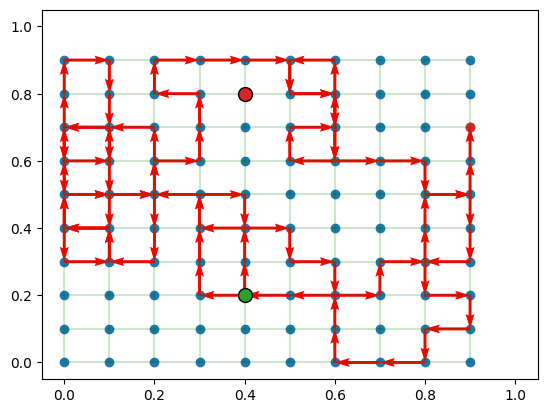

In [3]:
from SPPenv import SPPEnv
from utils import rollout, random_policy

batch_size = 3

env = SPPEnv(num_loc=100)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
print(reward)
env.render(td, actions)

In [4]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy

env = SPPEnv(num_loc=100)

# policy = AttentionModelPolicy(env.name, 
#                               embedding_dim=128, 
#                               num_encoder_layers=3,
#                               num_heads=8,)

# policy = AutoregressivePolicy(
#     env=env,
#     model=policy,
#     max_steps=100,
#     rollout_fn=rollout,
#     rollout_kwargs={"policy": greedy},
# )

# Instantiate policy with the embeddings we created above
emb_dim = 128
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=SPPInitEmbedding(emb_dim),
                              context_embedding=SPPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)

# model = AttentionModel(env, baseline="rollout",
#                        policy=policy,
#                        train_data_size=100_000,
#                        val_data_size=100_00,
#                        optimizer_kwargs= {"lr": 1e-4},)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=20,
                       val_data_size=5,)

/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/timo/projects/vt-ece/ece5984_drl_ai4spp/.venv/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: -4.000
Problem 2 | Cost: -7.000
Problem 3 | Cost: -6.000


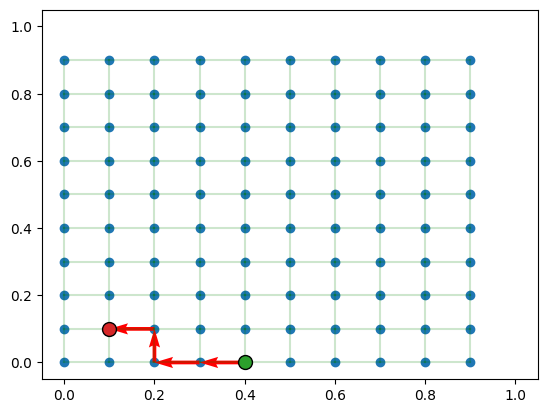

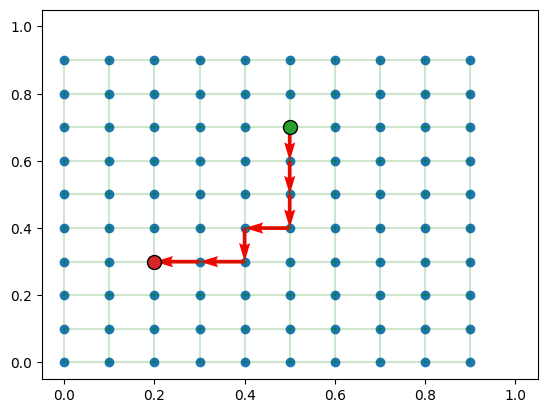

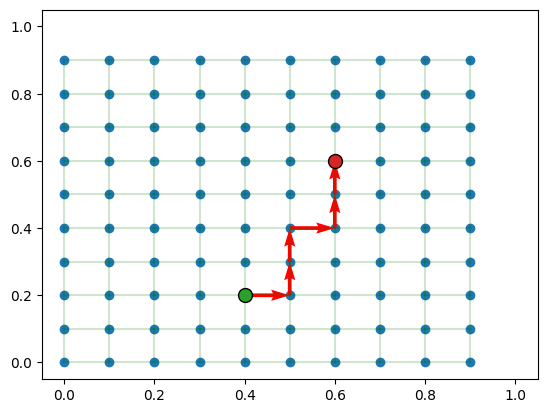

In [94]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [88]:
model.policy.train_decode_type = "sampling"
trainer = RL4COTrainer(
    max_epochs=10,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type                 | Params
--------------------------------------------------
0 | env      | SPPEnv               | 0     
1 | policy   | AutoregressivePolicy | 726 K 
2 | baseline | WarmupBaseline       | 726 K 
--------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.815     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  5.48it/s, v_num=125, train/reward=inf.0, train/loss=nan.0, val/reward=6.800]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  4.64it/s, v_num=125, train/reward=inf.0, train/loss=nan.0, val/reward=6.800]


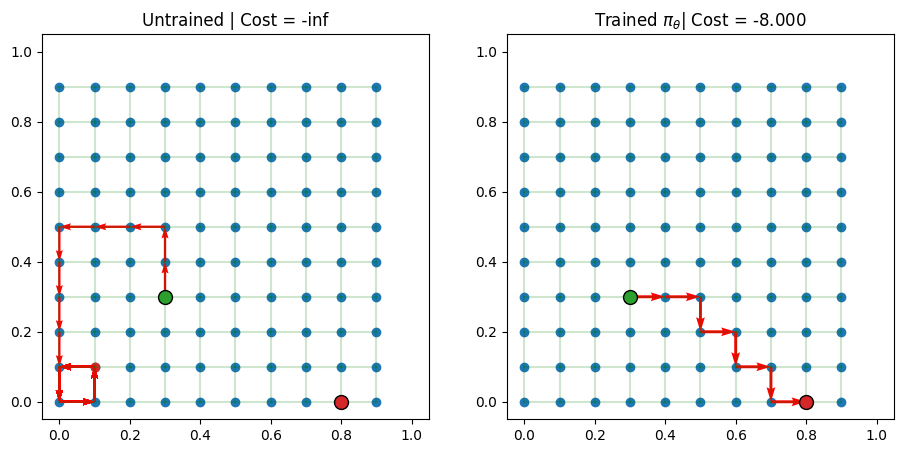

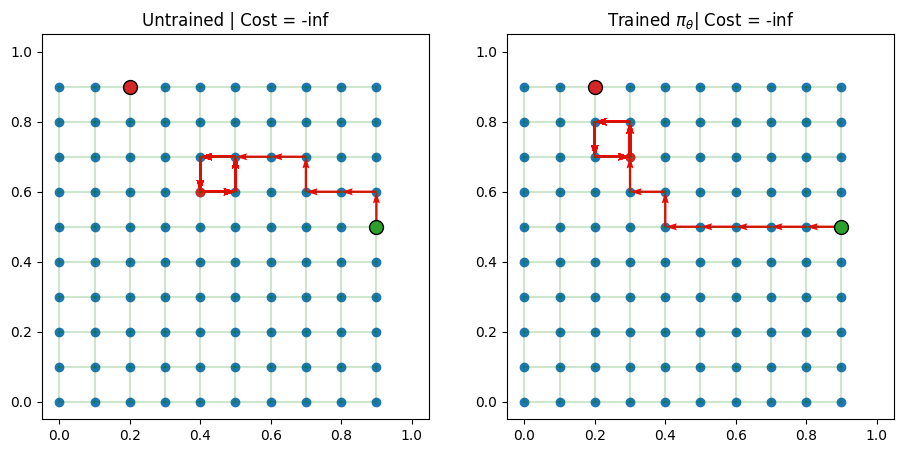

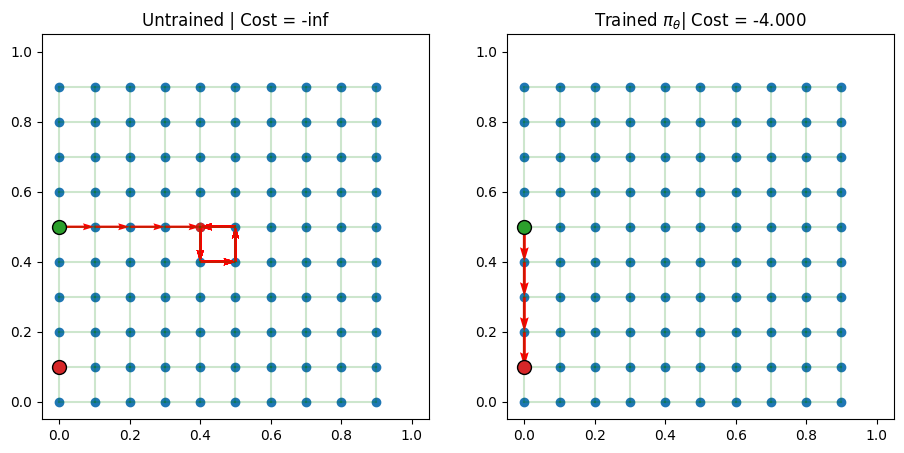

In [90]:
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    env.render(td, actions_trained[i], ax=axs[1])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")